In [1]:
import sys,os
sys.path=["../../QA-sim","../../april/py"]+sys.path
print(sys.path)
from Parameter import Parameter
from BaseLikelihood import BaseLikelihood
import MCMCAnalyzer
import numpy as np
import quasim as qua
import math
import matplotlib.pyplot as plt
import corner
from uncertainties import ufloat
from uncertainties.umath import sqrt
from scipy.optimize import minimize
from scipy.optimize import fsolve

['../../QA-sim', '../../april/py', '/home/Zhi/QA-sim/notebook', '/usr/lib64/python310.zip', '/usr/lib64/python3.10', '/usr/lib64/python3.10/lib-dynload', '', '/home/Zhi/.local/lib/python3.10/site-packages', '/usr/lib64/python3.10/site-packages', '/usr/lib/python3.10/site-packages', '/usr/lib/python3.10/site-packages/IPython/extensions', '/home/Zhi/.ipython']


In [2]:
# Create Input data
# Create star pair position placed in the E-W direction. Dec=0

QT = qua.QuaTel(A=10.0, ph=0.0)
BSC = qua.BSC_process("/home/Zhi/QA-sim/bsc5.dat")

# Filter out the best star pair to observe at December.
pos = BSC.BSC_filter(obs_t = 3)
print(pos)

lam = 0.55*10**(-6)

# Baseline vector in [B_EW,B_NS,L=latitude]
B = [200.,0.,0.71]

# Use some sample star, here I use sample pos[0] as a sample star
T = [-10000,10000]      #[-10000,+10000]
source = pos[0]

extra_ra =(source[0,1]+source[1,1])/2
source -= np.array([[0.0,extra_ra+3*np.pi/2,0.0,0.0],[0.0,extra_ra+3*np.pi/2,0.0,0.0]])

print('source after modification: ',source)

boost = 1.0

posNum, t_pos, posPhase = QT.get_num_photon(source,B,lam,T,'pos')
posData = qua.sim_data(posNum[0]*boost, t_pos, posPhase[0],'pos')   
posPhase = None
posNum = None

print('Positive Data Done')

negNum, t_neg, negPhase = QT.get_num_photon(source,B,lam,T,'neg')
negData = qua.sim_data(negNum[0]*boost,t_neg, negPhase[0],'neg')
negPhase = None
negNum = None

print("Negative Data done")

[[[5.05500000e+03 3.50785000e+00 9.58563914e-01 9.57417549e+01]
  [5.05400000e+03 3.50778455e+00 9.58626940e-01 4.49884866e+02]]]
source after modification:  [[ 5.05500000e+03 -4.71235626e+00  9.58563914e-01  9.57417549e+01]
 [ 5.05400000e+03 -4.71242171e+00  9.58626940e-01  4.49884866e+02]]
Positive Data Done
Negative Data done


[0.00314474]


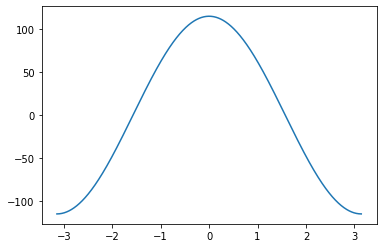

In [3]:
# Prints to see how dot product changes over time.
def dot_(p,source,baseline, latitude = 0.71):
    x = np.cos(source[:,2])*np.cos(source[:,1]-p)
    y = np.cos(source[:,2])*np.sin(source[:,1]-p)
    z = np.sin(source[:,2])
    
    mid_x = (x[0]+x[1])/2
    mid_y = (y[0]+y[1])/2
    mid_z = (z[0]+z[1])/2
    
    dx = x[0]-x[1]
    dy = y[0]-y[1]
    dz = (z[0]-z[1]) - np.sin(latitude)
    
    
    maximum = np.sqrt(dy**2+dx**2+dz**2)*np.sqrt(baseline[0]**2+baseline[1]**2)
    #para = -baseline[1]*np.sin(baseline[2])*dx + baseline[0]*dy + baseline[1]*np.cos(baseline[2])*dz
    ortho = -baseline[1]*np.sin(baseline[2])*mid_x + baseline[0]*mid_y + baseline[1]*np.cos(baseline[2])*mid_z
   
    return ortho
    #return para

x= np.linspace(-np.pi,np.pi,1000)
y = []

for i in x:
    yi = dot_(i,source,B)
    y.append(yi)
    
plt.plot(x,y)
print(x[np.where(y==np.amax(y))])

In [4]:
# Defines the Likelihood 
class sim_like(BaseLikelihood):
    
    def __init__(self, seed, pos_t, pos_s, lam, t_pos = None, t_neg = None):  # seed = [V_init,d_ra_init, d_dec_init]
        BaseLikelihood.__init__(self,"sim_data")  
        
        # free par
        self.seed = seed
        self.V = seed[0]
        self.d_ew = seed[1]
        self.d_ns = seed[2]
        self.offset = seed[3]
        
        # fixed values
        self.t_pos = t_pos             # timestamp for the sim data
        self.t_neg = t_neg
        
        self.baseline = np.array(pos_t)
        
        pos_s = np.delete(pos_s, 0, axis=1)  # delete star # part.
        self.pos_s = pos_s     # position of sources to determine midpoint
        
        self.lam = lam         # lambda for observation
        self.Omega_E = 7.292e-5

    def freeParameters(self):
    # Adjust err or bounds accordingly for constrained triangle plots
        return [
                Parameter("V", self.seed[0], err=0.04,bounds=(0.0,1.0)),    #0.1 for 1arcsec ,bounds=(-0.1,0.7)
                Parameter("d_ew",self.seed[1], err=5e-10,),   #5e-10
                Parameter("d_ns",self.seed[2], err=15e-10,),   #12e-10 for 1arcsec, 5e-10 for 15arcsec
                Parameter("offset",self.seed[3], err=np.pi/10,bounds=(-np.pi,np.pi)),   #bounds=(-np.pi,np.pi)
                ]
    
    def updateParams(self,params):    #params is also a class, updates param value.
        for p in params:
            if p.name=="V":
                self.V=p.value
            if p.name=="d_ew":
                self.d_ew=p.value
            if p.name=="d_ns":
                self.d_ns=p.value
            if p.name=="offset":
                self.offset=p.value
                
        
    def source_pos(self,ti):
        N = ti.size
        M = len(self.pos_s)  
            
        PHI = self.pos_s[:,0]
        PHI_mid = np.tile((PHI[0]+PHI[1])/2,(N))-self.Omega_E*ti
        DEC = self.pos_s[:,1]
        DEC_mid = np.tile((DEC[0]+DEC[1])/2,(N))  
            
        dx = -np.sin(DEC_mid)*np.cos(PHI_mid)*self.d_ns - self.d_ew*np.sin(PHI_mid)
        dy = -np.sin(DEC_mid)*np.sin(PHI_mid)*self.d_ns + self.d_ew*np.cos(PHI_mid)
        dz = self.d_ns * np.cos(DEC_mid)
        
        new_posi = np.column_stack((dx,dy,dz))
        
        return new_posi

    
    
    def get_phase(self):
        if self.t_pos is not None:
            new_pos_s = self.source_pos(self.t_pos)
            dot = -self.baseline[1]*np.sin(self.baseline[2])*new_pos_s[:,0] \
               + self.baseline[0] *new_pos_s[:,1] \
               +self.baseline[1]*np.cos(self.baseline[2])*new_pos_s[:,2]
       
            phase_pos = 2*np.pi/self.lam*dot + self.offset   # Total phase with the offset for plus mode
            
        
        if self.t_neg is not None:
            new_pos_s = self.source_pos(self.t_neg)
            
            dot = -self.baseline[1]*np.sin(self.baseline[2])*new_pos_s[:,0] \
               + self.baseline[0] *new_pos_s[:,1] \
               +self.baseline[1]*np.cos(self.baseline[2])*new_pos_s[:,2]
       
            phase_neg = 2*np.pi/self.lam*dot + self.offset   # Total phase with the offset for plus mode
                        
        
        if (self.t_neg is None and self.t_pos is not None):
            
            return phase_pos
        
        elif (self.t_neg is not None and self.t_pos is None):
            
            return phase_neg
        
        else:
            
            return [phase_pos,phase_neg]
        
    
    
    def loglike_wprior(self):
        phase = self.get_phase()
        
        if (self.t_neg is None and self.t_pos is not None):
           
            res = np.sum(np.log(1+self.V*np.cos(phase)) , axis=None)
            
        elif (self.t_neg is not None and self.t_pos is None):
  
            res = np.sum(np.log(1-self.V*np.cos(phase)), axis=None)
        
        else:

            res = np.sum(np.log(1+self.V*np.cos(phase[0])), axis=None) \
                    + np.sum(np.log(1-self.V*np.cos(phase[1])), axis=None)
            
        
        
        return res


In [5]:
# Find theoretical parameter values
d_ns_theo = source[0,2]-source[1,2]
d_ew_theo = np.cos((source[0,2]+source[1,2])/2)*(source[0,1]-source[1,1])
theo_par = np.array([posData.V,d_ew_theo,d_ns_theo,QT.ph])

def distance(s1,s2):
    DEC_mid = (s1[2]+s2[2])/2.0
    PHI_mid = (s1[1]+s2[1])/2.0
    d_DEC = s1[2]-s2[2] 
    d_PHI = s1[1]-s2[1]
    # Find theoretical separation
    dx = -np.sin(DEC_mid)*np.cos(PHI_mid)*d_DEC - d_PHI*np.cos(DEC_mid)*np.sin(PHI_mid)
    dy = -np.sin(DEC_mid)*np.sin(PHI_mid)*d_DEC + d_PHI*np.cos(DEC_mid)*np.cos(PHI_mid)
    dz = d_DEC * np.cos(DEC_mid)
    
    theo_d = np.sqrt(dx**2+dy**2+dz**2)
    
    return theo_d

theo_d = distance(source[0],source[1])
print("Theoretical separation: ", theo_d)
print("Theoretical Parameter: ", theo_par)

L= sim_like(theo_par, B, source, lam, t_pos = posData.timestamp, t_neg = negData.timestamp)
print("Current likelihood: ", L.loglike_wprior())

Theoretical separation:  7.339561468310582e-05
Theoretical Parameter:  [ 1.69154507e-01  3.76120658e-05 -6.30257785e-05  0.00000000e+00]
Current likelihood:  21.972498754966942


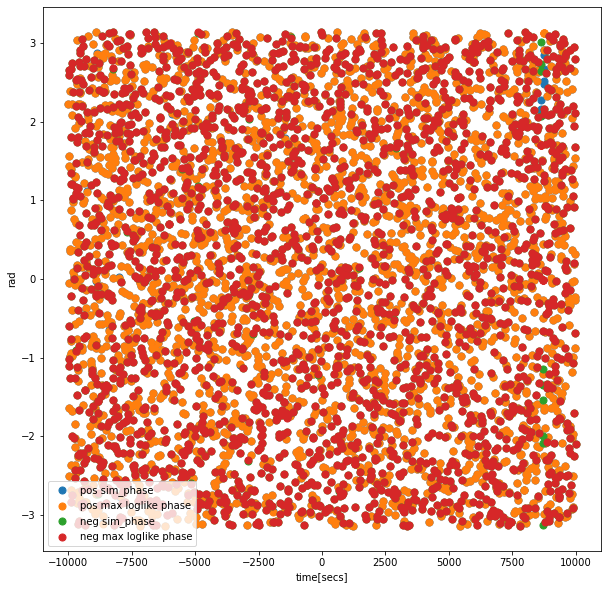

In [6]:
# Theoretical sim_phase data should overlap with pos max loglike data.
plt.figure(figsize=(10,10))

plt.scatter(posData.timestamp[:],np.mod((posData.phase[:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'pos sim_phase')
plt.scatter(posData.timestamp[:], np.mod((L.get_phase()[0][:]+ np.pi),2*np.pi) - np.pi, s= 50,label = 'pos max loglike phase')

plt.scatter(negData.timestamp[:],np.mod((negData.phase[:]+ np.pi),2*np.pi) - np.pi,s=50, label = 'neg sim_phase')
plt.scatter(negData.timestamp[:], np.mod((L.get_phase()[1][:]+ np.pi),2*np.pi) - np.pi, s= 50,label = 'neg max loglike phase')
plt.xlabel('time[secs]');plt.ylabel('rad')

plt.legend()

In [7]:
# Run the MCMC
MCMCAnalyzer.MCMCAnalyzer(L,"../output/output_data",temp=2, nsamp=300000)

Bounds: [ 0.00000000e+00  3.76095658e-05 -6.30332785e-05 -3.14159265e+00] [ 1.00000000e+00  3.76145658e-05 -6.30182785e-05  3.14159265e+00]
Starting chain...
Accepted samples 1000 2
Accepted samples 2000 1
Accepted samples 3000 1
Accepted samples 4000 1
Accepted samples 5000 2
Re-initializing covariance matrix after burn-in
[[ 1.10647458e-03 -5.66478381e-14 -6.86302521e-12 -1.19251429e-02]
 [-5.66478381e-14  5.00237475e-20 -1.45422488e-20 -1.77981277e-11]
 [-6.86302521e-12 -1.45422488e-20  2.39815376e-19  3.80956315e-10]
 [-1.19251429e-02 -1.77981277e-11  3.80956315e-10  6.56797634e-01]]
V 0.10492916211018258 0.033263712652368424
d_ew 3.761220423992327e-05 2.2365989256937496e-10
d_ns -6.302433174270996e-05 4.897094812342939e-10
offset 2.765689687710797 0.810430523971832
New maxloglike 17.70135345871055
New maxloglike 19.016629659287602
New maxloglike 19.629665018953034
New maxloglike 21.315123066012063
New maxloglike 21.924310167502334
New maxloglike 23.22234180889251
New maxloglike 23

Accepted samples 273000 1
Accepted samples 274000 1
Accepted samples 275000 3
Accepted samples 276000 1
Accepted samples 277000 3
Accepted samples 278000 2
Accepted samples 279000 2
Accepted samples 280000 1
Accepted samples 281000 3
Accepted samples 282000 3
Accepted samples 283000 1
Accepted samples 284000 6
Accepted samples 285000 1
Accepted samples 286000 1
Accepted samples 287000 1
Accepted samples 288000 6
Accepted samples 289000 1
Accepted samples 290000 3
Accepted samples 291000 1
Accepted samples 292000 2
Accepted samples 293000 1
Accepted samples 294000 2
Accepted samples 295000 8
Accepted samples 296000 1
Accepted samples 297000 3
Accepted samples 298000 6
Accepted samples 299000 3
Accepted samples 300000 1


Theoretical parameter:  [ 1.69154507e-01  3.76120658e-05 -6.30257785e-05  0.00000000e+00]
Sigma ew from general formula = 0.03934030351699219
Sigma ns from general formula = 0.06592175156361987
590004
Sigma from MCMC = [0.03110914 0.05705347 0.18858345 1.56749886]


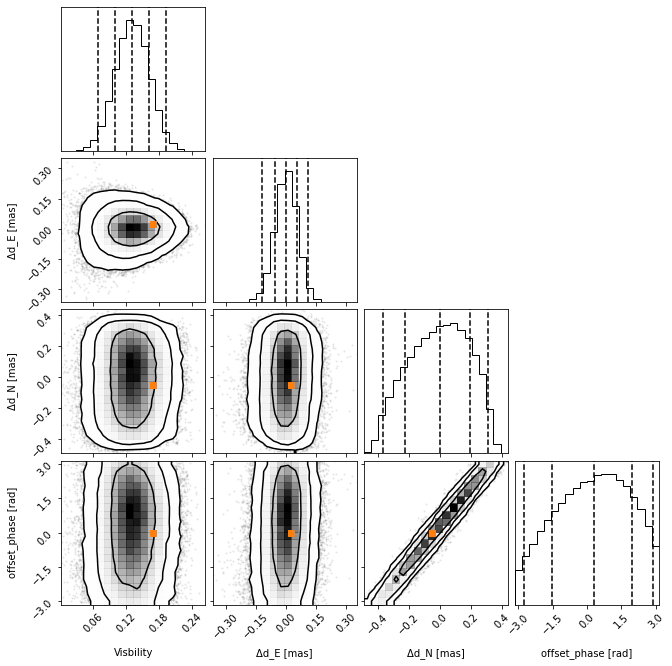

In [8]:
print('Theoretical parameter: ', theo_par)
res = np.loadtxt("../output/output_data.txt")
mcmc_data = np.delete(np.delete(res, [0,1], axis=1),np.s_[:int(res[:,0].size/2)], axis=0) 

# Find Sigma using formula in the paper:
k = (1-np.sqrt(1-posData.V**2))/posData.V**2

# Using the General formula:
theo_sigma_ew = np.absolute(np.sqrt(6/(k*np.pi**2))/posData.V/np.sqrt(2*T[1]*posData.avg_rate)*theo_par[1]/posData.N)  #
theo_sigma_ns = np.absolute(np.sqrt(6/(k*np.pi**2))/posData.V/np.sqrt(2*T[1]*posData.avg_rate)*theo_par[2]/posData.N) 
print("Sigma ew from general formula =", theo_sigma_ew/4.8481368e-9/np.sqrt(2.0))
print("Sigma ns from general formula =", theo_sigma_ns/4.8481368e-9/np.sqrt(2.0))

# Find center point of d_ew and d_ns
d_ew_mid = corner.quantile(mcmc_data[:,1],0.5)
d_ns_mid = corner.quantile(mcmc_data[:,2],0.5)

mcmc_data[:,1] = (mcmc_data[:,1] - d_ew_mid)/4.8481368e-9
mcmc_data[:,2] = (mcmc_data[:,2] - d_ns_mid)/4.8481368e-9

theo_par[1] = (theo_par[1] - d_ew_mid)/4.8481368e-9
theo_par[2] = (theo_par[2] - d_ns_mid)/4.8481368e-9

print(mcmc_data.size)
figure = corner.corner(mcmc_data,labels=['Visbility','Δd_E [mas]','Δd_N [mas]','offset_phase [rad]'],quantiles=(0.023, 0.16, 0.5, 0.84,0.977),levels=(0.68,0.952,0.994))
corner.overplot_points(figure, np.array(list(theo_par))[None], marker="s", color="C1",label="Theo")
figure.savefig('../output/output_data.jpg',facecolor='white')

# Find sigma from the MCMC by calculating the square root of covariance matrix
sigma = np.sqrt(np.cov(mcmc_data,rowvar=False).diagonal())
print("Sigma from MCMC =",sigma)